# Analysis of CICIoT2023 dataset


In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


ModuleNotFoundError: No module named 'tqdm'

In [2]:
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 4.1 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
DATASET_DIRECTORY = 'Datasets/CICIoT2023/'

### Importing Dataset

In [4]:
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()
len(df_sets)

169

In [5]:
N = 145

In [6]:
data_frames = []
for i in range(N):
    data_frames.append(pd.read_csv(DATASET_DIRECTORY + df_sets[i]))
len(data_frames)

145

In [7]:
def count_classes(data_frames):
    count_frame = pd.DataFrame()
    for i in range(N):
        count_frame[f"Data Frame {i}"] = data_frames[i]["label"].value_counts()
    print(count_frame.sum(axis=1))
    del count_frame

In [8]:
X_columns = ['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS','TCP', 'UDP',  'ICMP',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']
y_column = 'label'

In [9]:
for i in range(N):
    data_frames[i] = data_frames[i][X_columns + [y_column]]

## Converting 34 labels into (7+1) labels

In [10]:
dict_7classes = {}
# dict_7classes['DDoS-RSTFINFlood'] = 'DDoS'
# dict_7classes['DDoS-PSHACK_Flood'] = 'Other'
dict_7classes['DDoS-SYN_Flood'] = 'DDoS'
dict_7classes['DDoS-UDP_Flood'] = 'DDoS'
dict_7classes['DDoS-TCP_Flood'] = 'DDoS'
dict_7classes['DDoS-ICMP_Flood'] = 'DDoS'
# dict_7classes['DDoS-SynonymousIP_Flood'] = 'DDoS'
# dict_7classes['DDoS-ACK_Fragmentation'] = 'DDoS'
# dict_7classes['DDoS-UDP_Fragmentation'] = 'DDoS'
# dict_7classes['DDoS-ICMP_Fragmentation'] = 'DDoS'
# dict_7classes['DDoS-SlowLoris'] = 'DDoS'
dict_7classes['DDoS-HTTP_Flood'] = 'DDoS'

dict_7classes['DoS-UDP_Flood'] = 'DoS'
dict_7classes['DoS-SYN_Flood'] = 'DoS'
dict_7classes['DoS-TCP_Flood'] = 'DoS'
dict_7classes['DoS-HTTP_Flood'] = 'DoS'


# dict_7classes['Mirai-greeth_flood'] = 'Mirai'
# dict_7classes['Mirai-greip_flood'] = 'Mirai'
# dict_7classes['Mirai-udpplain'] = 'Mirai'

# dict_7classes['Recon-PingSweep'] = 'Recon'
# dict_7classes['Recon-OSScan'] = 'Recon'
# dict_7classes['Recon-PortScan'] = 'Recon'
# dict_7classes['VulnerabilityScan'] = 'Recon'
# dict_7classes['Recon-HostDiscovery'] = 'Recon'

# dict_7classes['DNS_Spoofing'] = 'Spoofing'
# dict_7classes['MITM-ArpSpoofing'] = 'Spoofing'

dict_7classes['BenignTraffic'] = 'Benign'

# dict_7classes['BrowserHijacking'] = 'Web'
# dict_7classes['Backdoor_Malware'] = 'Web'
# dict_7classes['XSS'] = 'Web'
# dict_7classes['Uploading_Attack'] = 'Web'
# dict_7classes['SqlInjection'] = 'Web'
# dict_7classes['CommandInjection'] = 'Web'


# dict_7classes['DictionaryBruteForce'] = 'BruteForce'

In [11]:
for i in range(N):
    data_frames[i]['label'] = [dict_7classes[k] if k in dict_7classes else 'Other' for k in data_frames[i]['label']]

In [12]:
for i in range(N):
    data_frames[i] = data_frames[i][data_frames[i]['label'].isin(["Benign","DoS","DDoS"])]

In [13]:
count_classes(data_frames)

label
DDoS      17887556
DoS        6826638
Benign      926865
dtype: int64


In [14]:
X = data_frames[0][X_columns]
y = data_frames[0][y_column]
delete = data_frames[0]
data_frames[0] = None
del delete
for i in range(1,N):
    X = pd.concat([X, data_frames[i][X_columns]])
    y = pd.concat([y, data_frames[i][y_column]])
    delete  = data_frames[i]
    data_frames[i] = None
    del delete
del data_frames
X.shape

(25641059, 37)

In [15]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [16]:
X,y = RandomUnderSampler(sampling_strategy="not minority").fit_resample(X,y)

In [17]:
y.value_counts()

label
Benign    926865
DDoS      926865
DoS       926865
Name: count, dtype: int64

In [18]:
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder().fit(y)
y = label_encoder.transform(y)

In [19]:
y_label = label_encoder.inverse_transform([0,1,2])

In [20]:
y_label

array(['Benign', 'DDoS', 'DoS'], dtype=object)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, KFold
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
del X,y

In [24]:
import xgboost as xgb

In [70]:
params = {
    "use_label_encoder" : False,
    'colsample_bytree': 0.807108539532184,
    'gamma': 8.589069863665419,
    'max_depth': 17.0,
    'min_child_weight': 8.0,
    'reg_alpha': 143.0,
    'reg_lambda': 0.17367339636611923,
    'tree_method': 'auto',
    'eval_metric': 'mlogloss',
    'seed': 42,
}

In [71]:
ml_pipeline = Pipeline([
    ('scaler', RobustScaler()),  # Preprocessing step
    ('pca', PCA(n_components=2)),
    ('xgb', xgb.XGBClassifier(params))
])
ml_pipeline.fit(X_train, y_train)
y_pred = ml_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [68]:
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)

[0]	validation_0-mlogloss:1.06491                     
[1]	validation_0-mlogloss:1.08052                     
[2]	validation_0-mlogloss:1.14255                     
[3]	validation_0-mlogloss:1.17207                     
[4]	validation_0-mlogloss:1.24484                     
[5]	validation_0-mlogloss:1.27374                     
[6]	validation_0-mlogloss:1.29962                     
[7]	validation_0-mlogloss:1.34305                     
[8]	validation_0-mlogloss:1.35604                     
[9]	validation_0-mlogloss:1.38074                     
[10]	validation_0-mlogloss:1.38771                    
[11]	validation_0-mlogloss:1.38999                    
[12]	validation_0-mlogloss:1.39448                    
[13]	validation_0-mlogloss:1.43089                    
[14]	validation_0-mlogloss:1.45801                    
[15]	validation_0-mlogloss:1.45624                    
[16]	validation_0-mlogloss:1.45578                    
[17]	validation_0-mlogloss:1.52618                    
[18]	valid

In [69]:
best_hyperparams

{'colsample_bytree': 0.807108539532184,
 'gamma': 8.589069863665419,
 'max_depth': 17.0,
 'min_child_weight': 8.0,
 'reg_alpha': 143.0,
 'reg_lambda': 0.17367339636611923}

In [72]:
y_pred_test = ml_pipeline.predict(X_test)
accuracy_score(y_test, y_pred_test)

0.9932028936252852

In [73]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    185373
           1       0.99      0.99      0.99    185373
           2       0.99      0.99      0.99    185373

    accuracy                           0.99    556119
   macro avg       0.99      0.99      0.99    556119
weighted avg       0.99      0.99      0.99    556119



In [38]:
x = {column:v for column,v in zip(X_columns,model.feature_importances_)}
l = list(x.keys())
l.sort(key = (lambda e: x[e]),reverse=True)
for i in l:
    print(i,x[i])

IAT 0.34318499401733427
urg_count 0.10311646560278527
rst_count 0.08811648255413472
AVG 0.05523130539373153
Variance 0.054774785586327424
Tot size 0.04071227278891944
Magnitue 0.04016914549834735
Radius 0.03730872286536101
Protocol Type 0.024381610740389276
Header_Length 0.024381087270714304
flow_duration 0.022305854050997085
Std 0.02159508434734895
Covariance 0.020385981530905962
ack_flag_number 0.02034054655537516
ICMP 0.013651787172885232
Tot sum 0.013496369505167322
Srate 0.013067888911844388
Min 0.010384010166736166
Max 0.01017841409952251
Rate 0.010115752111756325
Weight 0.008353376728170391
Number 0.005311631594994326
UDP 0.005002968697641548
HTTPS 0.0042822252777134084
syn_count 0.0024550954033828003
Duration 0.0023049081565742185
fin_count 0.0019632613464656084
syn_flag_number 0.0011824481278995267
TCP 0.0008839408484620651
HTTP 0.0007721057780877378
ack_count 0.0005438128355572593
rst_flag_number 4.319559615942043e-05
fin_flag_number 1.34564370330746e-06
psh_flag_number 1.123

In [74]:
from joblib import dump
dump(ml_pipeline, 'tuned_xgb_pipeline_145_files_3_class.joblib')

['tuned_xgb_pipeline_145_files_3_class.joblib']

<h2>Model Execution</h2>

In [3]:
from joblib import load
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np
import xgboost
import subprocess
test_3 = load('tuned_xgb_pipeline_145_files_3_class.joblib')

test_data = pd.read_csv("pcap2csv/capture.pcap.csv")

X_columns = ['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS','TCP', 'UDP',  'ICMP',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']
y_column = 'label'
X = test_data[X_columns]
y_pred_test = test_3.predict(X)
test_data["Predictions"] = y_pred_test
idx_to_class = {0:"Benign",1:"DDOS", 2:"DOS"}
non_zero_indices = np.nonzero(y_pred_test)[0]
if len(non_zero_indices) > 10:
    max_pred = y_pred_test.max().item()
    for i in non_zero_indices:
        print(f"Possible {idx_to_class[max_pred]} attack at port: 80 by IP: {test_data.loc[i,"Source IP"]}")

attack_data = test_data[test_data["Predictions"].isin([1,2])]
hostile_ips = list(attack_data["Source IP"].unique())
for ip in hostile_ips:
    # _ = subprocess.run(['sudo','ufw','deny','from',ip],capture_output = False)
    print(f"Further packets from {ip} will be dropped")

Further packets from 10.38.1.110 will be dropped


In [ ]:
from joblib import load
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np
import xgboost
import subprocess
test_3 = load('tuned_xgb_pipeline_145_files_3_class.joblib')

test_data = pd.read_csv("pcap2csv/capture.pcap.csv")

X_columns = ['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS','TCP', 'UDP',  'ICMP',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']
y_column = 'label'
X = test_data[X_columns]
y_pred_test = test_3.predict(X)
idx_to_class = {0:"Benign",1:"DDOS", 2:"DOS"}
non_zero_indices = np.nonzero(y_pred_test)[0]
if len(non_zero_indices) > 10:
    max_pred = y_pred_test.max().item()
    for i in non_zero_indices:
        print(f"Possible {idx_to_class[max_pred]} attack at port: 80 by IP: {test_data.loc[i,"Source IP"]}")
print


In [5]:
attack_data = test_data[test_data["Predictions"].isin([1,2])]

In [133]:
hostile_ips = list(attack_data["Source IP"].unique())
hostile_ips

['10.38.1.110']

In [6]:
attack_data

,ts,Source Port,Destination Port,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,...,Variance,Weight,DS status,Fragments,Sequence number,Protocol Version,flow_idle_time,flow_active_time,Source IP,Predictions
0,1.723841e+09,4901.7,2.2,0.0,151.4,6.0,64.0,0.0,0.0,0.0,...,0.8,38.5,0.0,0.0,0.0,0.0,1.723841e+08,0.0,10.38.1.110,2


In [124]:
y = [0 for i in range(test_data.shape[0])]

In [125]:
print(classification_report(y, y_pred_test,zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [ ]:
df_corr = df[['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS',
       'SSH', 'TCP', 'UDP','ARP', 'ICMP', 'IPv', 'LLC',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight','label']].corr()

In [ ]:
print(df_corr["label"].sort_values(ascending=False, key=abs).to_markdown())

|                 |        label |
|:----------------|-------------:|
| label           |  1           |
| Protocol Type   |  0.45861     |
| Min             |  0.405704    |
| Magnitue        |  0.301441    |
| AVG             |  0.226213    |
| Tot size        |  0.225437    |
| Tot sum         |  0.222546    |
| UDP             |  0.170722    |
| ICMP            | -0.16666     |
| TCP             | -0.166117    |
| Header_Length   |  0.162468    |
| ack_flag_number | -0.126027    |
| fin_flag_number | -0.116865    |
| ack_count       | -0.110791    |
| psh_flag_number | -0.104059    |
| rst_flag_number | -0.103016    |
| urg_count       |  0.0920605   |
| HTTPS           | -0.0831803   |
| fin_count       | -0.0755288   |
| syn_count       | -0.0637364   |
| Max             |  0.0589227   |
| syn_flag_number | -0.0528001   |
| Variance        |  0.04683     |
| flow_duration   |  0.0457839   |
| Duration        | -0.0445295   |
| Std             | -0.0440355   |
| Radius          | 

[]

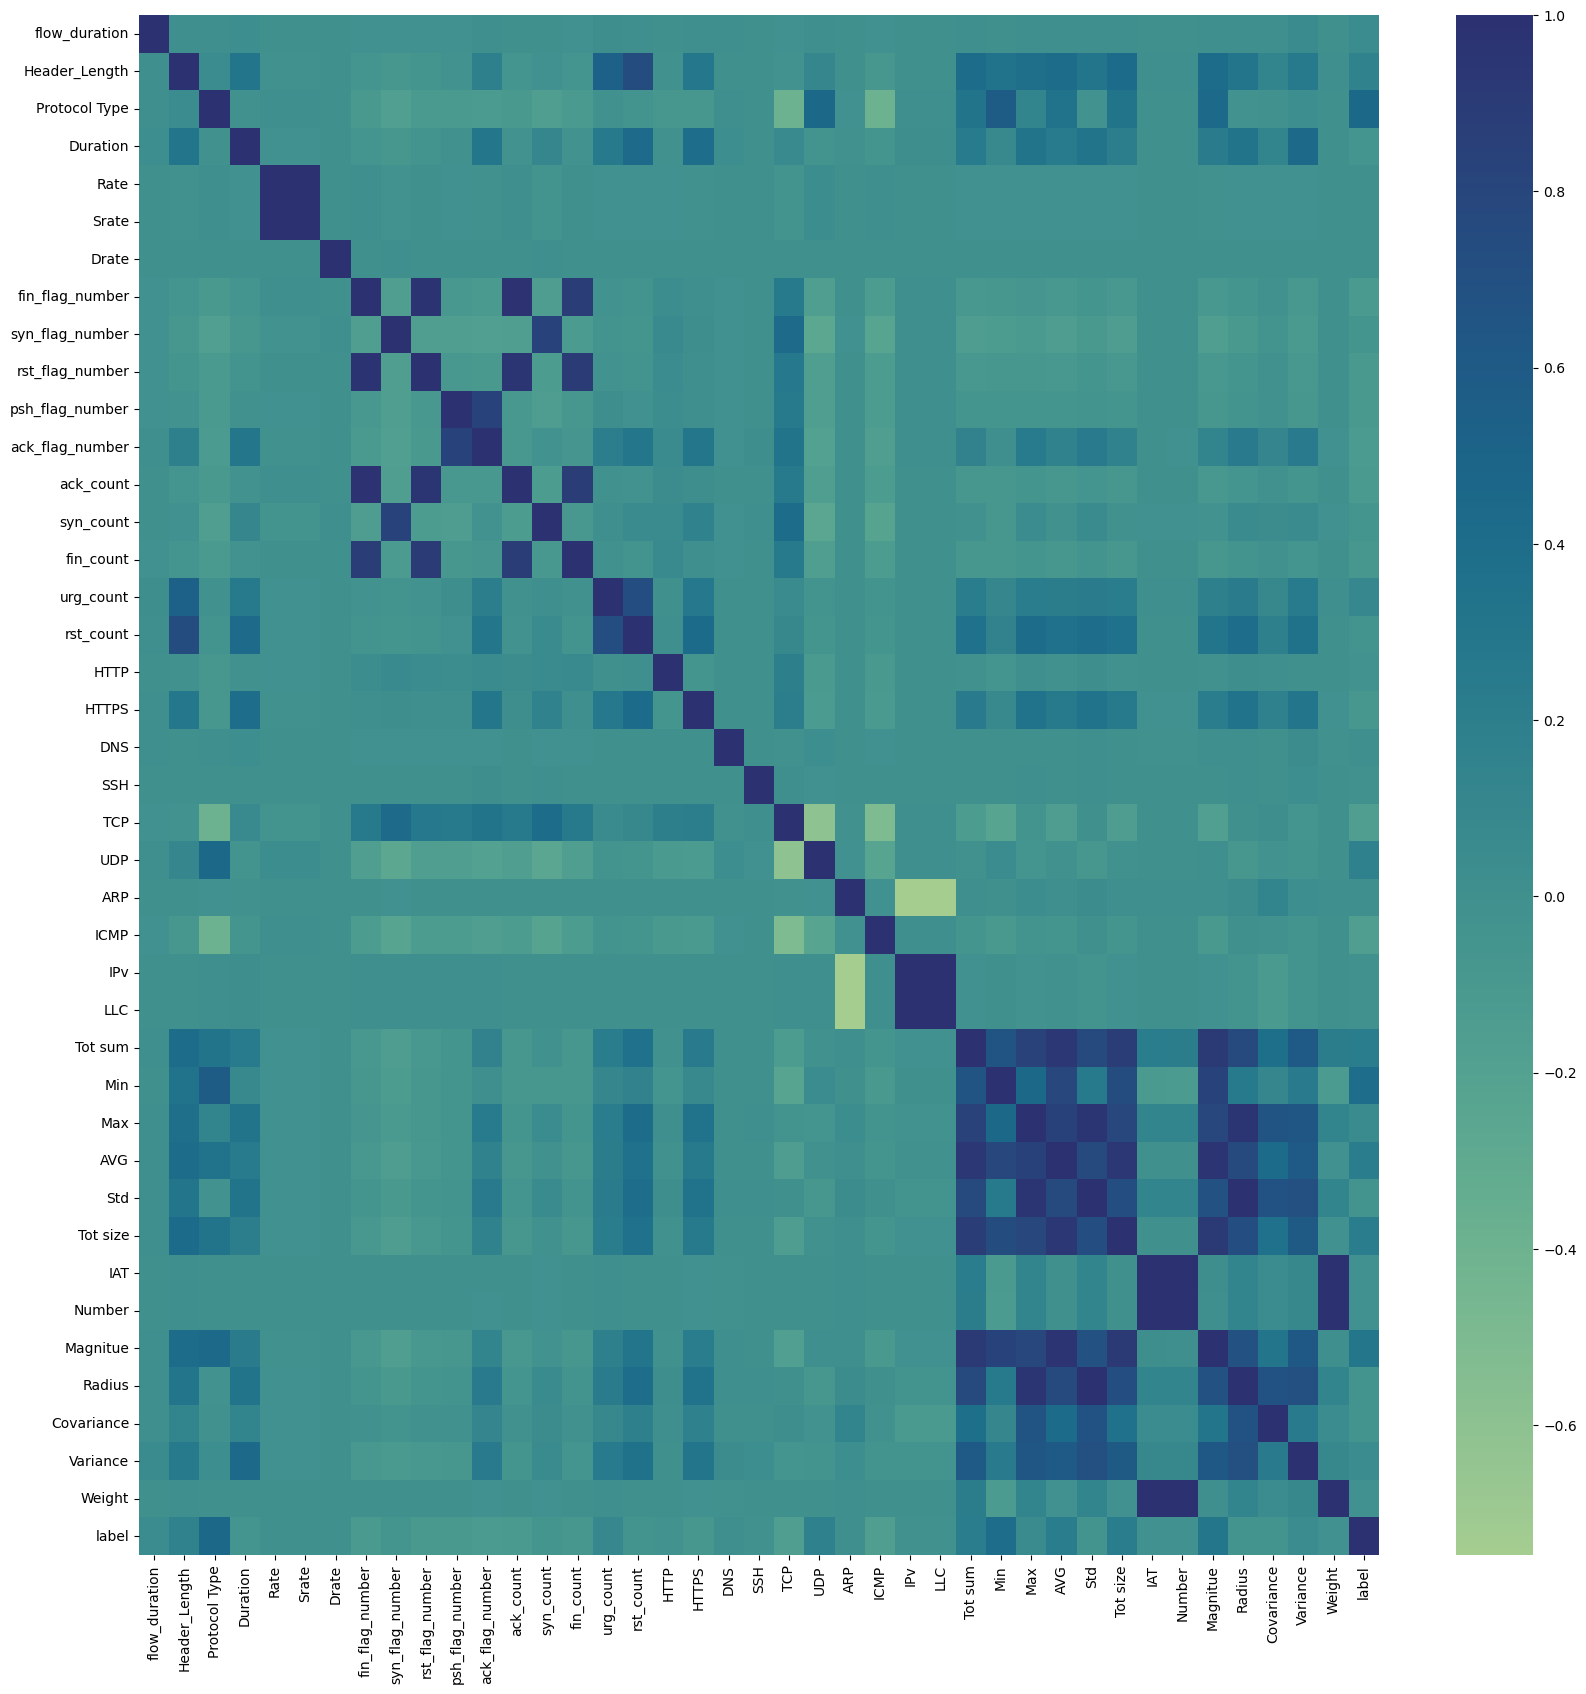

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(df_corr,cmap='crest',annot=False,)
plt.plot()

In [ ]:
df[df['label'] == 2]["TCP"].value_counts()


TCP
1.0    104662
0.0     69115
Name: count, dtype: int64

In [ ]:
print(df[df['label'] == 3]["Protocol Type"].value_counts().to_markdown())

In [ ]:
print(df[df['Protocol Type'] == 6]["label"].apply(lambda x: idx_to_class[x]).value_counts().to_markdown())

| label      |   count |
|:-----------|--------:|
| DDoS       |   89088 |
| DoS        |   19998 |
| Benign     |    2225 |
| Spoofing   |    1082 |
| Recon      |     738 |
| Web        |      24 |
| BruteForce |      19 |
| Mirai      |       2 |


In [ ]:
print(df[df['Protocol Type'] == 17]["label"].apply(lambda x: idx_to_class[x]).value_counts().to_markdown())

| label    |   count |
|:---------|--------:|
| DDoS     |   21296 |
| DoS      |   10104 |
| Mirai    |    2695 |
| Spoofing |     341 |
| Benign   |       9 |
| Recon    |       8 |
| Web      |       6 |


In [ ]:
X = df[X_columns]
y = df["label"]

In [ ]:

# Extract single tree
estimator = model.estimators_[5]

In [ ]:
from sklearn import tree
plt.figure(figsize=(25,20))
_ = tree.plot_tree(model.estimators_[0], feature_names=X.columns, filled=False)

In [ ]:
tree.export_graphviz(model.estimators_[0], out_file='tree.dot', feature_names=X.columns, filled=True)

In [ ]:
y_pred_test = model.predict(X_test)
accuracy_score(y_test, y_pred_test)

0.9931123474996648

In [ ]:
# View confusion matrix for test data and predictions
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1400
           1       0.00      0.00      0.00        16
           2       1.00      1.00      1.00     43444
           3       1.00      1.00      1.00     10319
           4       1.00      1.00      1.00      3359
           5       0.81      0.73      0.77       465
           6       0.84      0.79      0.81       635
           7       0.00      0.00      0.00        34

    accuracy                           0.99     59672
   macro avg       0.69      0.68      0.69     59672
weighted avg       0.99      0.99      0.99     59672



In [ ]:
idx_to_class = {k:v for k,v in zip(list(df['label'].unique()),label_encoder.inverse_transform(list(df['label'].unique())))}
idx_to_class

{2: 'DDoS',
 3: 'DoS',
 4: 'Mirai',
 0: 'Benign',
 6: 'Spoofing',
 5: 'Recon',
 7: 'Web',
 1: 'BruteForce'}

In [ ]:
try:
    import statsmodels.api as sm
except:
    !pip install statsmodels
    import statsmodels.api as sm

ols = sm.OLS(y, X)
est = ols.fit()

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     3582.
Date:                Sat, 06 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:59:57   Log-Likelihood:            -2.3502e+05
No. Observations:              238687   AIC:                         4.701e+05
Df Residuals:                  238649   BIC:                         4.705e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
flow_duration       0.0001   4.06e-06     24.838      0.000    9.28e-05       0.000
Header_Length    5.097e-07   5.42e-09     94.030      0.000    4.99e-07     5.2e-07
Protocol Type       0.0451      0.000     91.477      0.000       0.044       0.046
Duration           -0.0008      0.000     -6.676      0.000      -0.001      -0.001
Rate             1.631e-08   2.56e-08      0.637      0.524   -3.39e-08    6.65e-08
Srate           -1.611e-08   2.56e-08     -0.629      0.529   -6.63e-08    3.41e-08
Drate              -0.3465      0.751     -0.461      0.645      -1.819       1.126
fin_flag_number    -1.3958      0.037    -37.368      0.000      -1.469      -1.323
syn_flag_number    -0.1041      0.007    -14.626      0.000      -0.118      -0.090
rst_flag_number     0.4133      0.023     17.863      0.000       0.368       0.459
psh_flag_number     0.1023      0.013      7.854      0.000       0.077       0.128
ack_flag_number    -0.4379      0.013    -34.891      0.000      -0.463      -0.413
ece_flag_number  -2.88e-09    2.3e-08     -0.125      0.901    -4.8e-08    4.23e-08
cwr_flag_number -2.709e-08   4.51e-08     -0.601      0.548   -1.15e-07    6.12e-08
ack_count           0.3492      0.030     11.782      0.000       0.291       0.407
syn_count          -0.0204      0.004     -5.049      0.000      -0.028      -0.012
fin_count           0.2861      0.010     27.984      0.000       0.266       0.306
urg_count           0.0026   2.67e-05     97.725      0.000       0.003       0.003
rst_count          -0.0010   9.27e-06   -106.096      0.000      -0.001      -0.001
HTTP               -0.0276      0.006     -4.363      0.000      -0.040      -0.015
HTTPS              -0.1062      0.007    -14.734      0.000      -0.120      -0.092
DNS                 0.3710      0.103      3.609      0.000       0.170       0.572
Telnet          -1.193e-15   5.38e-15     -0.222      0.824   -1.17e-14    9.34e-15
SMTP            -1.408e-16   1.12e-15     -0.125      0.900   -2.34e-15    2.06e-15
SSH                -1.3080      0.196     -6.687      0.000      -1.691      -0.925
IRC             -3.144e-15   8.68e-15     -0.362      0.717   -2.01e-14    1.39e-14
TCP                 0.8638      0.016     53.840      0.000       0.832       0.895
UDP                 0.4155      0.012     34.321      0.000       0.392       0.439
DHCP            -2.557e-15   4.94e-15     -0.517      0.605   -1.22e-14    7.13e-15
ARP                 1.1033      0.204      5.395      0.000       0.702       1.504
ICMP                0.7393      0.018     41.545      0.000       0.704       0.774
IPv                -0.2132      0.069     -3.074      0.002      -0.349      -0.077
LLC                -0.2132      0.069     -3.074      0.002      -0.349      -0.077
Tot sum          5.008e-05   2.28e-06     21.962      0.000

In [ ]:
iter1_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
       'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ack_count',
       'syn_count', 'fin_count', 'urg_count', 'rst_count', 
    'HTTP', 'HTTPS', 'DNS', 'SSH', 'TCP',
       'UDP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
       'AVG', 'Std', 'IAT', 'Number', 'Magnitue',
       'Radius', 'Covariance', 'Variance', 'Weight', 
]
X1 = df[iter1_columns]
ols = sm.OLS(y, X1)
est = ols.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     4017.
Date:                Sat, 06 Apr 2024   Prob (F-statistic):               0.00
Time:                        23:09:21   Log-Likelihood:            -2.3502e+05
No. Observations:              238687   AIC:                         4.701e+05
Df Residuals:                  238653   BIC:                         4.705e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
flow_duration       0.0001   4.06e-06     24.832      0.000    9.28e-05       0.000
Header_Length    5.095e-07    5.4e-09     94.318      0.000    4.99e-07     5.2e-07
Protocol Type       0.0450      0.000     93.089      0.000       0.044       0.046
Duration           -0.0008      0.000     -6.787      0.000      -0.001      -0.001
fin_flag_number    -1.3958      0.037    -37.387      0.000      -1.469      -1.323
syn_flag_number    -0.1039      0.007    -14.621      0.000      -0.118      -0.090
rst_flag_number     0.4135      0.023     17.874      0.000       0.368       0.459
psh_flag_number     0.1031      0.013      7.973      0.000       0.078       0.128
ack_flag_number    -0.4387      0.012    -35.214      0.000      -0.463      -0.414
ack_count           0.3489      0.030     11.783      0.000       0.291       0.407
syn_count          -0.0205      0.004     -5.087      0.000      -0.028      -0.013
fin_count           0.2862      0.010     27.989      0.000       0.266       0.306
urg_count           0.0026   2.66e-05     98.074      0.000       0.003       0.003
rst_count          -0.0010   9.26e-06   -106.215      0.000      -0.001      -0.001
HTTP               -0.0276      0.006     -4.355      0.000      -0.040      -0.015
HTTPS              -0.1064      0.007    -14.792      0.000      -0.120      -0.092
DNS                 0.3700      0.103      3.600      0.000       0.169       0.571
SSH                -1.3080      0.196     -6.687      0.000      -1.691      -0.925
TCP                 0.8627      0.016     54.225      0.000       0.831       0.894
UDP                 0.4149      0.012     34.442      0.000       0.391       0.439
ARP                 1.1056      0.204      5.409      0.000       0.705       1.506
ICMP                0.7381      0.018     41.784      0.000       0.704       0.773
IPv                -0.2125      0.069     -3.064      0.002      -0.348      -0.077
LLC                -0.2125      0.069     -3.064      0.002      -0.348      -0.077
Tot sum          4.965e-05   2.13e-06     23.260      0.000    4.55e-05    5.38e-05
Min                 0.0007   3.67e-05     19.876      0.000       0.001       0.001
AVG                -0.0011   3.88e-05    -27.145      0.000      -0.001      -0.001
Std                -0.0067      0.001     -8.055      0.000      -0.008      -0.005
IAT             -6.582e-09   1.35e-09     -4.863      0.000   -9.24e-09   -3.93e-09
Number              0.3383      0.039      8.736      0.000       0.262       0.414
Magnitue            0.0243      0.001     23.860      0.000       0.022       0.026
Radius              0.0041      0.001      6.972      0.000       0.003       0.005
Covariance       1.247e-07   5.15e-09     24.213      0.000    1.15e-07    1.35e-07
Variance            0.4533      0.012     39.308      0.000

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X1, y,train_size=0.8,random_state=1, stratify=y)
model2 = RandomForestClassifier(n_estimators=10)
# Train
model2.fit(X_train,y_train)
y_pred_test = model2.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1120
           1       0.50      0.08      0.13        13
           2       1.00      1.00      1.00     34756
           3       1.00      1.00      1.00      8255
           4       1.00      1.00      1.00      2687
           5       0.78      0.67      0.73       372
           6       0.81      0.76      0.79       508
           7       0.00      0.00      0.00        27

    accuracy                           0.99     47738
   macro avg       0.75      0.68      0.69     47738
weighted avg       0.99      0.99      0.99     47738



In [ ]:
x = {column:v for column,v in zip(iter1_columns,model2.feature_importances_)}
l = list(x.keys())
l.sort(key = (lambda e: x[e]),reverse=True)
for i in l:
    print(i,x[i])

IAT 0.4802360670101999
flow_duration 0.08681733451068395
Tot sum 0.0613619968171906
Magnitue 0.05098841333120392
Min 0.04844551463086995
AVG 0.04347850271122482
Header_Length 0.039929914007245534
rst_count 0.025519985161717506
urg_count 0.023771194400204677
Protocol Type 0.02330050868732314
Std 0.0162959719371073
Variance 0.013350987997628985
Weight 0.01142206303852333
UDP 0.010015473612459889
Covariance 0.009167969936443494
syn_count 0.008573865652947389
ICMP 0.008098705831210837
Number 0.007697773894342655
Radius 0.006936080414993509
TCP 0.0062154410945341396
Duration 0.005233319135882846
ack_count 0.004062887554015767
fin_count 0.0027397891371782066
HTTPS 0.0017312041624217215
fin_flag_number 0.0013720857967570803
psh_flag_number 0.0009529403282932744
ack_flag_number 0.0006815693551039764
HTTP 0.0006498087159633048
rst_flag_number 0.0005758557432549636
syn_flag_number 0.0002514331536192659
SSH 5.810373770765077e-05
DNS 2.6270665313258147e-05
LLC 2.1206632293892127e-05
IPv 1.23494239

In [ ]:
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(estimator=RandomForestClassifier()).fit(X_train, y_train)
X1_train = selector.transform(X_train)
X1_test = selector.transform(X_test)

In [ ]:
model2.fit(X1_train,y_train)
y_pred_test = model2.predict(X1_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1120
           1       0.86      0.46      0.60        13
           2       1.00      1.00      1.00     34756
           3       1.00      1.00      1.00      8255
           4       1.00      1.00      1.00      2687
           5       0.85      0.75      0.79       372
           6       0.82      0.73      0.77       508
           7       0.33      0.07      0.12        27

    accuracy                           0.99     47738
   macro avg       0.84      0.74      0.77     47738
weighted avg       0.99      0.99      0.99     47738



# Classification: 2 (1+1) Classes

In [ ]:
dict_2classes = {}
dict_2classes['DDoS-RSTFINFlood'] = 'Attack'
dict_2classes['DDoS-PSHACK_Flood'] = 'Attack'
dict_2classes['DDoS-SYN_Flood'] = 'Attack'
dict_2classes['DDoS-UDP_Flood'] = 'Attack'
dict_2classes['DDoS-TCP_Flood'] = 'Attack'
dict_2classes['DDoS-ICMP_Flood'] = 'Attack'
dict_2classes['DDoS-SynonymousIP_Flood'] = 'Attack'
dict_2classes['DDoS-ACK_Fragmentation'] = 'Attack'
dict_2classes['DDoS-UDP_Fragmentation'] = 'Attack'
dict_2classes['DDoS-ICMP_Fragmentation'] = 'Attack'
dict_2classes['DDoS-SlowLoris'] = 'Attack'
dict_2classes['DDoS-HTTP_Flood'] = 'Attack'

dict_2classes['DoS-UDP_Flood'] = 'Attack'
dict_2classes['DoS-SYN_Flood'] = 'Attack'
dict_2classes['DoS-TCP_Flood'] = 'Attack'
dict_2classes['DoS-HTTP_Flood'] = 'Attack'


dict_2classes['Mirai-greeth_flood'] = 'Attack'
dict_2classes['Mirai-greip_flood'] = 'Attack'
dict_2classes['Mirai-udpplain'] = 'Attack'

dict_2classes['Recon-PingSweep'] = 'Attack'
dict_2classes['Recon-OSScan'] = 'Attack'
dict_2classes['Recon-PortScan'] = 'Attack'
dict_2classes['VulnerabilityScan'] = 'Attack'
dict_2classes['Recon-HostDiscovery'] = 'Attack'

dict_2classes['DNS_Spoofing'] = 'Attack'
dict_2classes['MITM-ArpSpoofing'] = 'Attack'

dict_2classes['BenignTraffic'] = 'Benign'

dict_2classes['BrowserHijacking'] = 'Attack'
dict_2classes['Backdoor_Malware'] = 'Attack'
dict_2classes['XSS'] = 'Attack'
dict_2classes['Uploading_Attack'] = 'Attack'
dict_2classes['SqlInjection'] = 'Attack'
dict_2classes['CommandInjection'] = 'Attack'

dict_2classes['DictionaryBruteForce'] = 'Attack'

In [ ]:
new_y = [dict_2classes[k] for k in df[y_column]]
df["Attack"]  = new_y

KeyError: 2

<BarContainer object of 2 artists>

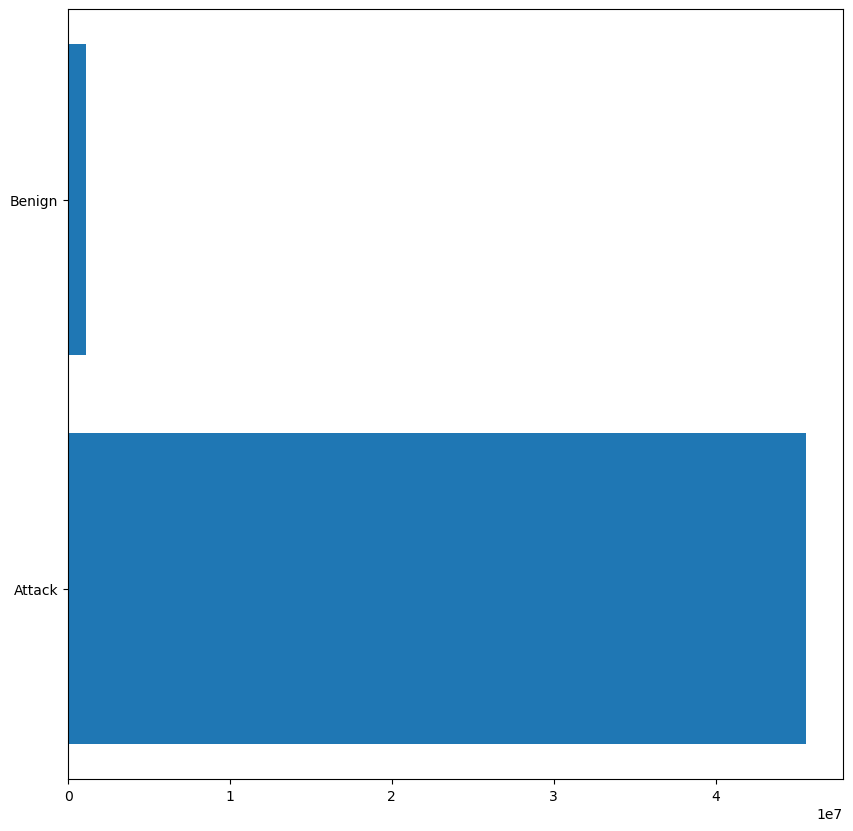

In [ ]:
packet_label = list(dict(df['Attack'].value_counts(sort=True)).keys())
count = list(dict(frame['Attack'].value_counts(sort=True)).values())
fig = plt.figure(figsize = (10, 10))
plt.barh(packet_label,count)

In [ ]:
label_to_idx = {labels[i]:i for i in range(len(labels))}
label_to_idx

{'DDoS-RSTFINFlood': 0,
 'DoS-TCP_Flood': 1,
 'DDoS-ICMP_Flood': 2,
 'DoS-UDP_Flood': 3,
 'DoS-SYN_Flood': 4,
 'Mirai-greeth_flood': 5,
 'DDoS-SynonymousIP_Flood': 6,
 'Mirai-udpplain': 7,
 'DDoS-SYN_Flood': 8,
 'DDoS-PSHACK_Flood': 9,
 'DDoS-TCP_Flood': 10,
 'DDoS-UDP_Flood': 11,
 'BenignTraffic': 12,
 'MITM-ArpSpoofing': 13,
 'DDoS-ACK_Fragmentation': 14,
 'Mirai-greip_flood': 15,
 'DoS-HTTP_Flood': 16,
 'DDoS-ICMP_Fragmentation': 17,
 'Recon-PortScan': 18,
 'DNS_Spoofing': 19,
 'DDoS-UDP_Fragmentation': 20,
 'Recon-OSScan': 21,
 'XSS': 22,
 'DDoS-HTTP_Flood': 23,
 'Recon-HostDiscovery': 24,
 'CommandInjection': 25,
 'VulnerabilityScan': 26,
 'DDoS-SlowLoris': 27,
 'Backdoor_Malware': 28,
 'BrowserHijacking': 29,
 'DictionaryBruteForce': 30,
 'SqlInjection': 31,
 'Recon-PingSweep': 32,
 'Uploading_Attack': 33}

# CICIDS

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
DATASET_DIRECTORY = 'CICIDS/'

### Importing Dataset

In [1]:
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()
len(df_sets)

NameError: name 'os' is not defined

In [5]:
data_frames = []
for i in range(len(df_sets)):
    data_frames.append(pd.read_csv(DATASET_DIRECTORY + df_sets[i]))
len(data_frames)

8

In [6]:
def count_classes(data_frames):
    count_frame = pd.DataFrame()
    for i in range(len(data_frames)):
        count_frame[f"Data Frame {i}"] = data_frames[i][" Label"].value_counts()
    print(count_frame.sum(axis=1))
    del count_frame

In [7]:
count_classes(data_frames)

 Label
DDoS       128027.0
BENIGN    2273097.0
dtype: float64


In [12]:
df = pd.concat(data_frames)
del data_frames

In [22]:
cic_cols

Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
       'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'label'],
      dtype='object')

common columns
- flow_duration
- header length
- 

In [14]:
df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [11]:
df[''].describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,...,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06
mean,8.071483e+03,1.478566e+07,9.361160e+00,1.039377e+01,5.493024e+02,1.616264e+04,2.075999e+02,1.871366e+01,5.820194e+01,6.891013e+01,...,5.418218e+00,-2.741688e+03,8.155132e+04,4.113412e+04,1.531825e+05,5.829582e+04,8.316037e+06,5.038439e+05,8.695752e+06,7.920031e+06
std,1.828363e+04,3.365374e+07,7.496728e+02,9.973883e+02,9.993589e+03,2.263088e+06,7.171848e+02,6.033935e+01,1.860912e+02,2.811871e+02,...,6.364257e+02,1.084989e+06,6.485999e+05,3.933815e+05,1.025825e+06,5.770923e+05,2.363008e+07,4.602984e+06,2.436689e+07,2.336342e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,1.550000e+02,2.000000e+00,1.000000e+00,1.200000e+01,0.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,3.131600e+04,2.000000e+00,2.000000e+00,6.200000e+01,1.230000e+02,3.700000e+01,2.000000e+00,3.400000e+01,0.000000e+00,...,1.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,3.204828e+06,5.000000e+00,4.000000e+00,1.870000e+02,4.820000e+02,8.100000e+01,3.600000e+01,5.000000e+01,2.616295e+01,...,2.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [21]:
from sklearn import preprocessing

In [22]:
df[' Label'] =preprocessing.LabelEncoder().fit_transform(df[' Label'])

In [23]:
df_corr = df.corr()

In [30]:
print(df_corr[" Label"].sort_values(ascending=False, key=abs).to_markdown())

|                             |         Label |
|:----------------------------|--------------:|
| Label                       |   1           |
| PSH Flag Count              |   0.305413    |
| Min Packet Length           |  -0.254473    |
| Bwd Packet Length Min       |  -0.227019    |
| Fwd IAT Std                 |   0.205842    |
| Idle Mean                   |   0.187675    |
| Idle Min                    |   0.187095    |
| Idle Max                    |   0.186252    |
| Fwd IAT Max                 |   0.182371    |
| Bwd Packet Length Std       |   0.18216     |
| Flow IAT Max                |   0.181158    |
| Bwd Packet Length Max       |   0.171966    |
| Bwd Packet Length Mean      |   0.158172    |
| Avg Bwd Segment Size        |   0.158172    |
| Packet Length Variance      |   0.155879    |
| Flow IAT Std                |   0.15293     |
| Packet Length Std           |   0.151829    |
| Max Packet Length           |   0.149638    |
| URG Flag Count              |  -0.1151

In [1]:
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type',
       'Rate', 'Srate', 'urg_count', 'rst_count','Tot sum', 'Min',
       'Max', 'AVG', 'Tot size', 'IAT', 'Magnitue', 
]

In [ ]:
common_columns = ["psh flag count",""]